# My 10 Stepped Approach

* Step1- Not to use time series forecasting methods as the series is not regular and data is missing.
* Step2- Visualizing the data.
* Step3- Extracting various features from 'date' column.
* Step4-Bucketing the 'hour' column in 4 parts as per the 'demand' trend across various hours( though it didnt helped in reducing the RMSE)
* Step5- Dropping the highly correlated features.
* Step6- Building and tuning HistGradientBoostingRegressor model.
* Step7- Fitting DecisionTreeRegressor model and tuning it so that it can be used as an estimator in AdaBoostRegressor model.
* Step8- Building and tuning AdaBoostRegressor model.
* Step9- Building VotingRegressor using AdaBoostRegressor & HistGradientBoostingRegressor models,to make build final model.
* Step10- Fitting VotingRegressor model on whole dataset and submitting the predictions on test data set.

# Loading Necessary Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats
%matplotlib inline

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error 
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import VotingRegressor
from sklearn.model_selection import RandomizedSearchCV

import warnings
warnings.filterwarnings('ignore')

### Loading Dataset

In [2]:
df=pd.read_csv('train_E1GspfA.csv')
df_test=pd.read_csv('test_6QvDdzb.csv')

In [3]:
df.head()

,date,hour,demand
0,2018-08-18,9,91
1,2018-08-18,10,21
2,2018-08-18,13,23
3,2018-08-18,14,104
4,2018-08-18,15,81


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18247 entries, 0 to 18246
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   date    18247 non-null  object
 1   hour    18247 non-null  int64 
 2   demand  18247 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 427.8+ KB


# Step1- Checking for missing data percentage, if Time Series Forecasting methods to be used.

In [3]:
print(df.date.head(1))
print(df.date.tail(1))
print(df_test.date.head(1))
print(df_test.date.tail(1))


0    2018-08-18
Name: date, dtype: object
18246    2021-02-28
Name: date, dtype: object
0    2021-03-01
Name: date, dtype: object
7649    2022-03-28
Name: date, dtype: object


#### Dates in train set ranges from 18/08/2018 to 28/02/2021
#### Dates in test set ranges from 01/03/2021 to 28/03/2022

In [4]:
date_train=pd.date_range(start='2018-08-18',end='2021-02-28',freq='H')
date_test=pd.date_range(start='2021-03-01',end='2022-03-28',freq='H')

In [5]:
missing_dates_train=(len(date_train)-len(df))/len(date_train)*100
print('missing dates percentage in train data set',missing_dates_train)
missing_dates_test=(len(date_test)-len(df_test))/len(date_test)*100
print('missing dates percentage in train data set',missing_dates_test)

missing dates percentage in train data set 17.810008558173056
missing dates percentage in train data set 18.694866617068765


### So, i didn't used Time Series Forecasting algorithms.

# Step2- Visualising the data

### 'hour'

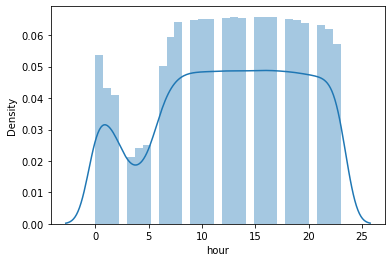

In [6]:
sns.distplot(df['hour']);

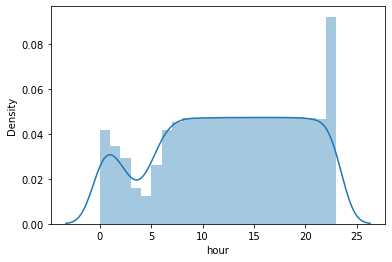

In [7]:
sns.distplot(df_test['hour']);

### 'demand'

<AxesSubplot:xlabel='demand', ylabel='Density'>

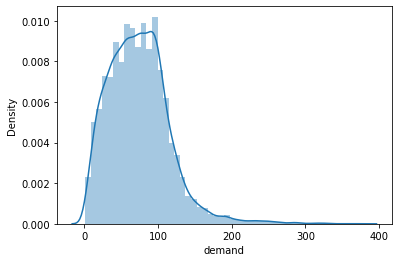

In [8]:
sns.distplot(df['demand'])

### hour-demand

<AxesSubplot:xlabel='hour', ylabel='demand'>

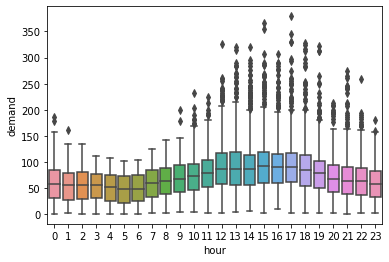

In [9]:
sns.boxplot(df['hour'],df['demand'])

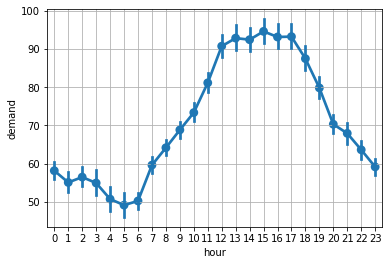

In [10]:
sns.pointplot(df['hour'],df['demand'])
plt.grid()

# Step3- Feature Engineering using 'date' Column

In [5]:
df1=pd.read_csv('train_E1GspfA.csv',parse_dates=True)
df1_test=pd.read_csv('test_6QvDdzb.csv',parse_dates=True)

In [7]:
df1.head()

,date,hour,demand
0,2018-08-18,9,91
1,2018-08-18,10,21
2,2018-08-18,13,23
3,2018-08-18,14,104
4,2018-08-18,15,81


### Seperating the 'date' variable in various constituents of date

In [12]:
df1['Year'] = pd.to_datetime(df1['date']).dt.year
df1['Quarter'] = pd.to_datetime(df1['date']).dt.quarter
df1['Month'] = pd.to_datetime(df1['date']).dt.month
df1['Week'] = pd.to_datetime(df1['date']).dt.week
df1['Day'] = pd.to_datetime(df1['date']).dt.day
df1['Day_of_Week'] = pd.to_datetime(df1['date']).dt.dayofweek
df1['Day_of_year'] = pd.to_datetime(df1['date']).dt.dayofyear


df1_test['Year'] = pd.to_datetime(df1_test['date']).dt.year
df1_test['Quarter'] = pd.to_datetime(df1_test['date']).dt.quarter
df1_test['Month'] = pd.to_datetime(df1_test['date']).dt.month
df1_test['Week'] = pd.to_datetime(df1_test['date']).dt.week
df1_test['Day'] = pd.to_datetime(df1_test['date']).dt.day
df1_test['Day_of_Week'] = pd.to_datetime(df1_test['date']).dt.dayofweek
df1_test['Day_of_Year'] = pd.to_datetime(df1_test['date']).dt.dayofyear


### Further Seperating the 'weekdays' and 'weekends'

In [13]:
df1['Week_end'] = np.where(df1['Day_of_Week'].isin([5,6]),1,0)
df1['Week_day'] = np.where(df1['Day_of_Week'].isin([0,1,2,3,4]),1,0)
df1_test['Week_end'] = np.where(df1_test['Day_of_Week'].isin([5,6]),1,0)
df1_test['Week_day'] = np.where(df1_test['Day_of_Week'].isin([0,1,2,3,4]),1,0)

# Step4- Feature Engineering using 'hour' Column

### Further Seperating the 'hour' in different buckets as per 'demand' variations

In [14]:
df1['HOURS']=pd.cut(df.hour,[0,5,13,17,23],labels=['1','2','3','4'])
df1_test['HOURS']=pd.cut(df1_test.hour,[0,5,13,17,23],labels=['1','2','3','4'])

df1['HOURS']=pd.Categorical(df1['HOURS']).codes
df1_test['HOURS']=pd.Categorical(df1_test['HOURS']).codes

# Step5- Dropping highly correlated features

### Checking for correlation between various features

<AxesSubplot:>

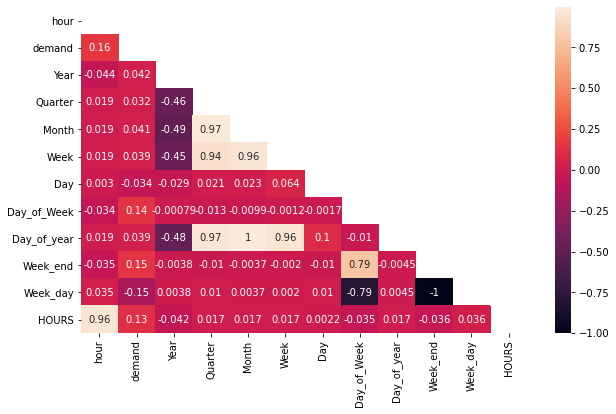

In [15]:
corr=df1.corr()
plt.figure(figsize=(10,6))
sns.heatmap(corr,annot=True,mask=np.triu(corr))

<AxesSubplot:>

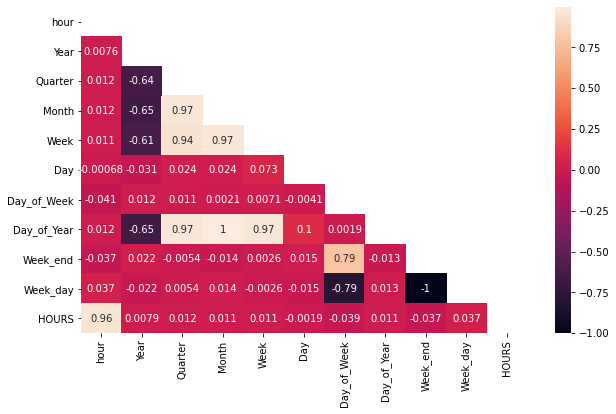

In [16]:
corr_test=df1_test.corr()
plt.figure(figsize=(10,6))
sns.heatmap(corr_test,annot=True,mask=np.triu(corr_test))

### Dropping the highly correlated variables

In [17]:
df1=df1.drop(['Quarter','Month','Week','Week_end'],axis=1)
df1_test=df1_test.drop(['Quarter','Month','Week','Week_end'],axis=1)

# Step6- Building the model- HistGradientBoosting 

In [18]:
x= df1.drop(['demand','date'],axis= 1)
y= df1.pop('demand')

In [19]:
x_train,x_test,y_train,y_test= train_test_split(x,y,random_state=1,test_size=.20)

In [20]:
model_HIST = HistGradientBoostingRegressor(random_state=1)
params_HIST = {'learning_rate':list(np.arange(0.01,0.1,0.005)),
             'max_iter':list(np.arange(50,1000,50)),'max_leaf_nodes':list(np.arange(3,70,2)),
               'min_samples_leaf': list(np.arange(3,70,2)),
               'loss' : ('squared_error', 'absolute_error', 'poisson')}
grid_search_HIST = RandomizedSearchCV(estimator = model_HIST, param_distributions = params_HIST, 
                                     cv = 5,n_jobs=-1,random_state=1)
grid_search_HIST.fit(x_train,y_train.values.ravel())
HIST_model=grid_search_HIST.best_estimator_
grid_search_HIST.best_params_


{'min_samples_leaf': 7,
 'max_leaf_nodes': 45,
 'max_iter': 700,
 'loss': 'squared_error',
 'learning_rate': 0.08999999999999998}

In [21]:
y_train_predict_HIST_model = HIST_model.predict(x_train)
y_test_predict_HIST_model = HIST_model.predict(x_test)

print(np.sqrt(mean_squared_error(y_train,y_train_predict_HIST_model)))
print(np.sqrt(mean_squared_error(y_test,y_test_predict_HIST_model)))

29.29991859082799
31.57014742420945


# Step7- Building the model- DecisionTreeRegressor

In [22]:
dt= DecisionTreeRegressor()
param_dt = {'max_depth': [11],'min_samples_leaf': [13],'min_samples_split': [3]}
grid_search_dt = GridSearchCV(estimator = dt, param_grid = param_dt, cv = 5)
grid_search_dt.fit(x_train, y_train)
print(grid_search_dt.best_estimator_)

best_grid_dt = grid_search_dt.best_estimator_
y_train_predict_dt_tuned = best_grid_dt.predict(x_train)
y_test_predict_dt_tuned = best_grid_dt.predict(x_test)

print(np.sqrt(mean_squared_error(y_train,y_train_predict_dt_tuned)))
print(np.sqrt(mean_squared_error(y_test,y_test_predict_dt_tuned)))

DecisionTreeRegressor(max_depth=11, min_samples_leaf=13, min_samples_split=3)
30.502332272065278
33.68043786421228


# Step8- Building the model- AdaBoostRegressor

In [23]:
ada_tuned = AdaBoostRegressor(random_state=1,base_estimator=best_grid_dt,n_estimators=300,
                              loss='exponential')
ada_tuned.fit(x_train, y_train)

y_train_predict_ada_tuned = ada_tuned.predict(x_train)
y_test_predict_ada_tuned = ada_tuned.predict(x_test)

print(np.sqrt(mean_squared_error(y_train,y_train_predict_ada_tuned)))
print(np.sqrt(mean_squared_error(y_test,y_test_predict_ada_tuned)))

27.98015384631573
31.628228071826662


# Step9- Building the model- VotingRegressor

In [24]:
estim_list = [('ada_tuned',ada_tuned),('HIST_model',HIST_model)]
VOT_model = VotingRegressor(estimators = estim_list)
VOT_model.fit(x_train,y_train.values.ravel())

y_train_predict_voting = VOT_model.predict(x_train)
y_test_predict_voting = VOT_model.predict(x_test)

print(np.sqrt(mean_squared_error(y_train,y_train_predict_voting)))
print(np.sqrt(mean_squared_error(y_test,y_test_predict_voting)))

28.35243820594269
31.336563474461087


# Step10- Making predictions and submission

In [25]:
model=VOT_model
model.fit(x,y)

VotingRegressor(estimators=[('ada_tuned',
                             AdaBoostRegressor(base_estimator=DecisionTreeRegressor(max_depth=11,
                                                                                    min_samples_leaf=13,
                                                                                    min_samples_split=3),
                                               loss='exponential',
                                               n_estimators=300,
                                               random_state=1)),
                            ('HIST_model',
                             HistGradientBoostingRegressor(learning_rate=0.08999999999999998,
                                                           max_iter=700,
                                                           max_leaf_nodes=45,
                                                           min_samples_leaf=7,
                                                           random_state=1))])

In [26]:
df_test_final=df1_test.drop(['date'],axis=1)
final_predictions = model.predict(df_test_final)
df_test['demand']=np.round(final_predictions)

In [27]:
df_test.head()

,date,hour,demand
0,2021-03-01,0,58.0
1,2021-03-01,1,52.0
2,2021-03-01,2,54.0
3,2021-03-01,3,53.0
4,2021-03-01,5,51.0


In [28]:
df_test.to_csv('submission.csv',index = False)